# 🛠 1 Setup and Initialization

In [2]:
# @title Dependencies

import os
import math
import kagglehub
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# set our styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_style('darkgrid')

In [3]:
# @title Load Dataset

path = kagglehub.dataset_download("dgomonov/new-york-city-airbnb-open-data")
csv_file = os.path.join(path, "AB_NYC_2019.csv")

# import the data and specify an encoding to get notified if any columns are in an unexpected format that panadas cannot work with
# we'll also ensure that pandas convert the 'last_review' to a datetime to more accurately match the intended datatype
df = pd.read_csv(
    csv_file,
    encoding="ISO-8859-1",
    #parse_dates=["last_review"]
  )

100%|██████████| 2.44M/2.44M [00:00<00:00, 79.6MB/s]

Extracting files...


# 🔍 2. Exploratory Data Analysis

## 2.1: Structure

In [4]:
print(df.shape, "\n")

df.info()
df.head()

(48895, 16) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review       

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


**Observations**

- The dataset is made up of **16** atributes and **48,896** observations
- neighbourhood, neighbourhood_group and room_type are strings that represent categorical data
- last_review could be converted to a datetime


## 2.2: Data Distribution

Text(0.5, 1.0, 'Price Frequency Distribution')

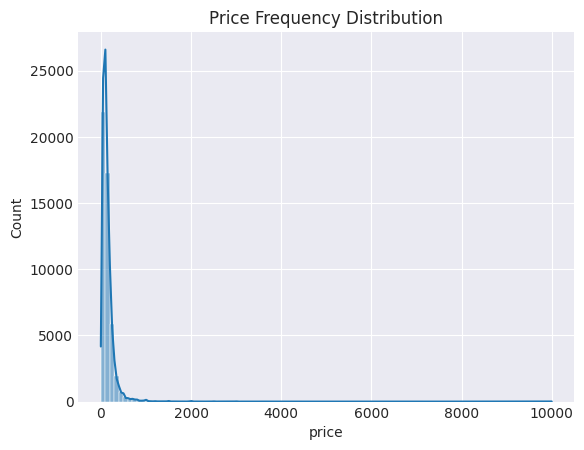

In [5]:
# @title Frequency distributions

sns.histplot(data=df, x='price', bins=100, kde=True).set_title('Price Frequency Distribution')

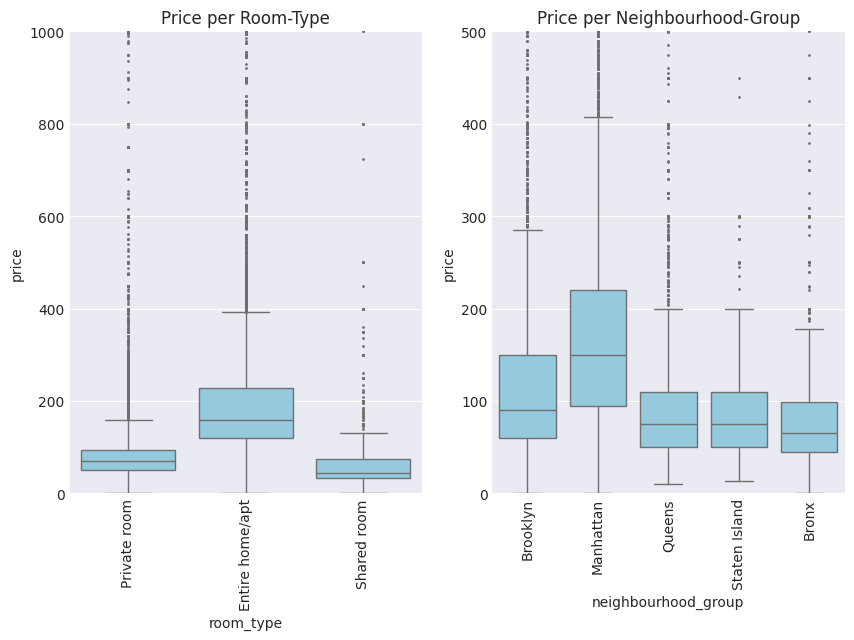

In [6]:
# @title Price distributions

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=False)

rt = sns.boxplot(data=df, x='room_type', y='price', ax=axes[0,], fliersize=1, color='skyblue')
rt.set_title('Price per Room-Type')
rt.set_ylim([0, 1000])
rt.tick_params("x",labelrotation=90)

ng = sns.boxplot(data=df, x='neighbourhood_group', y='price', ax=axes[1,], fliersize=1, color='skyblue')
ng.set_title('Price per Neighbourhood-Group')
ng.set_ylim([0, 500])
ng.tick_params("x",labelrotation=90)

**Observations**

- As observerd in the price-frequency distribution, the dataset is heavily right-skewed
- Further, the price per room-typoe and neighbourhood-group distributions show a lare number of outliers in the higer price ranges across the board
- Outlier removal will be nesecary as these values may distort our statistical measures and will also improve ML model performance
  

## 2.3: Missing reviews

In [7]:
# @title Missing review counts
missing_last_review = df['last_review'].isnull().sum()
print(f"Number of missing 'last_review': {missing_last_review}")
print(f"Percentage of missing 'last_review': {missing_last_review / len(df) * 100:.2f}%")

Number of missing 'last_review': 10052
Percentage of missing 'last_review': 20.56%


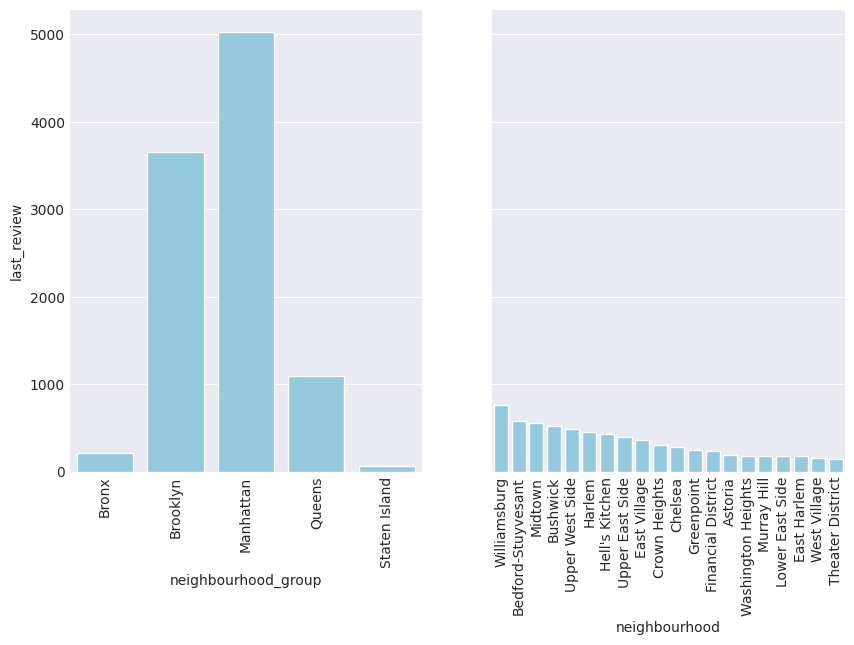

In [8]:
# @title Missing by neighbourhood and neighbourhood group

missing_by_ng = df.groupby('neighbourhood_group')['last_review'].apply(lambda x: x.isnull().sum())
missing_by_nb = df.groupby('neighbourhood')['last_review'].apply(lambda x: x.isnull().sum()).sort_values(ascending=False).head(20)

fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

plt1 = sns.barplot(data=missing_by_ng, color="skyblue", ax=axes[0,])
plt2 = plt_by_nb = sns.barplot(data=missing_by_nb, color="skyblue", ax=axes[1,])

plt1.tick_params("x",labelrotation=90)
plt2.tick_params("x",labelrotation=90)

## 2.3: Data Cleansing

### 📌 Data Cleaning Plan
Before we proceed with modeling, we need to **clean the dataset** to ensure data quality and accuracy.

#### 1️⃣ Removing Irrelevant Columns
We will **drop the `last_review` column** because:
- It has **10,052 missing values**.
- It does **not contribute** to our price prediction model.

#### 2️⃣ Handling Missing Values
We will take the following actions to handle missing values:

| Column | Issue | Action We Will Take |
|---------|-------|--------------------|
| `name` | 16 missing values | **Replace missing values with `"Unnamed Listing"`** |
| `host_name` | 21 missing values | **Replace missing values with `"Unknown"`** |
| `reviews_per_month` | 10,052 missing values | **Fill missing values with `0` (since missing means no reviews)** |


#### 3️⃣ Handle rows with invalid price values
We'll handle rows with invalid/zero prices:

| Column | Issue | Action We Will Take |
|---------|-------|--------------------|
| `price` | 11 zero values | **Due to the small number of records with zero prices we'll drop them** |


#### 🔍 Ensuring Dataset Integrity and Final Check
Once we complete the above steps, we will:
- **Verify that no missing values remain**.
- **Retain `name` and `host_name`** for potential insights later.

After completing data cleaning, we will run:
```python
df.isnull().sum()


In [9]:
# @title 2.3.1 Missing Values
df.isnull().sum()

,0
id,0
name,16
host_id,0
host_name,21
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


### 2.3.2 🛠 Handle Missing Values

In [10]:
# Drop the 'last_review' column since it's not useful
df = df.drop(columns=['last_review'])

# Fill missing values in 'reviews_per_month' with 0 (since no review means 0 per month)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# Replace missing host_name with "Unknown"
df['host_name'] = df['host_name'].fillna("Unknown")

# Fill missing values in 'name' with "Unnamed Listing"
df['name'] = df['name'].fillna("Unnamed Listing")

# Verify missing values are handled
df.isnull().sum()

,0
id,0
name,0
host_id,0
host_name,0
neighbourhood_group,0
neighbourhood,0
latitude,0
longitude,0
room_type,0
price,0


In [11]:
# @title 2.3.3 Handle rows with invalid price values

print("Before removal: ", df[df.price <= 0].shape[0])

# there's only 11 rows that have zero price, we'll remove them now as they are obviously incorrect
df = df[df.price > 0]

print("After removal: ", df[df.price <= 0].shape[0])

Before removal:  11
After removal:  0


## 2.4: Handling Outliers

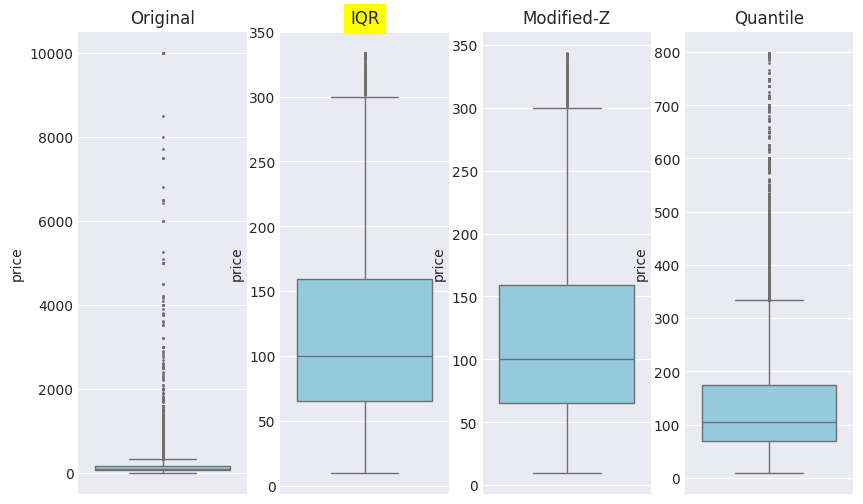

In [12]:
# @title Select an outlier detection method and apply it
# Sources: https://etheses.dur.ac.uk/2432/1/2432_443.pdf
# Sources: https://towardsdatascience.com/outlier-detection-part1-821d714524c/

# IQR method for outlier detection
q1 = df['price'].quantile(0.25)
q3 = df['price'].quantile(0.75)
iqr = q3 - q1

lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

df_iqr = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# modified z-score method for outlier detection
median = df['price'].median()
# calculate the median of the absolute deviations from the median
mad = np.median(np.abs(df['price'] - median))

modified_z_scores = 0.6745 * (df['price'] - median) / mad

# define a threshold
threshold = 3.5
df_mzs = df[modified_z_scores.abs() < threshold]

# simple quantile method
df_sqm = df[(df['price'] > 0) & (df['price'] <= df['price'].quantile(0.99))]

fig, axes = plt.subplots(1, 4, figsize=(10, 6), sharey=False)

bp_orig = sns.boxplot(data=df, y='price', ax=axes[0,], fliersize=1, color='skyblue').set_title('Original')
bp_iqr = sns.boxplot(data=df_iqr, y='price', ax=axes[1,], fliersize=1, color='skyblue').set_title('IQR')
bp_mzs = sns.boxplot(data=df_mzs, y='price', ax=axes[2,], fliersize=1, color='skyblue').set_title('Modified-Z')
bp_sqm = sns.boxplot(data=df_sqm, y='price', ax=axes[3,], fliersize=1, color='skyblue').set_title('Quantile')

# CHOICE: we choose the dataset without outliers here
df_clean = df_iqr.copy()
bp_iqr.set_backgroundcolor('yellow')


**Observation**

We'll choose the IQR method for removing outliers as it simpler to understand and yields a similar distribution than the Modified-Z method and does not leave as mnany outlieres as the simple quantile method.

In [13]:
# @title Observation Counts
before = df['id'].count()
after = df_clean['id'].count()
diff = before - after

print("Results from outlier removal:")
print("Original: ", before)
print("Cleaned:  ", after)
print("Removed:  ", diff, f'({(diff/before*100):.2f}%)')

Results from outlier removal:
Original:  48884
Cleaned:   45912
Removed:   2972 (6.08%)


### Price Frequency Distribution Before and After Outlier Removal

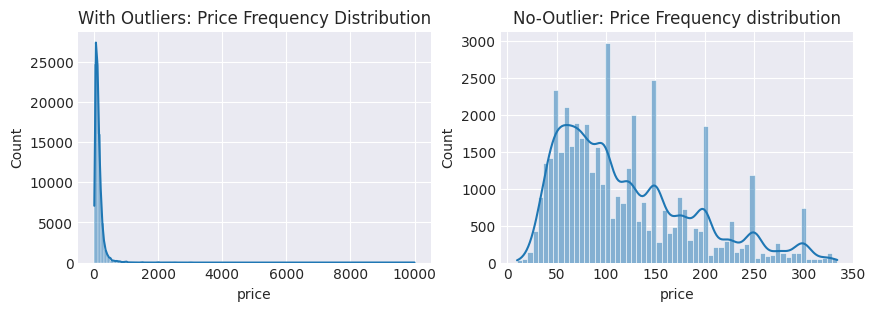

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=False)

sns.histplot(data=df, x='price', bins=100, kde=True, ax=axes[0,]).set_title('With Outliers: Price Frequency Distribution')
sns.histplot(data=df_clean, x='price', kde=True, ax=axes[1,]).set_title('No-Outlier: Price Frequency distribution')

# remove labels
plt.gca().spines[['top', 'right',]].set_visible(False)

**Observations:**

Frequency distribution is still right-sided, however, no longer have as affected by outliers as before.

### Room Type and Neighbourhood Group Frequency distributions Before and After Outlier Removal

<Axes: xlabel='neighbourhood_group'>

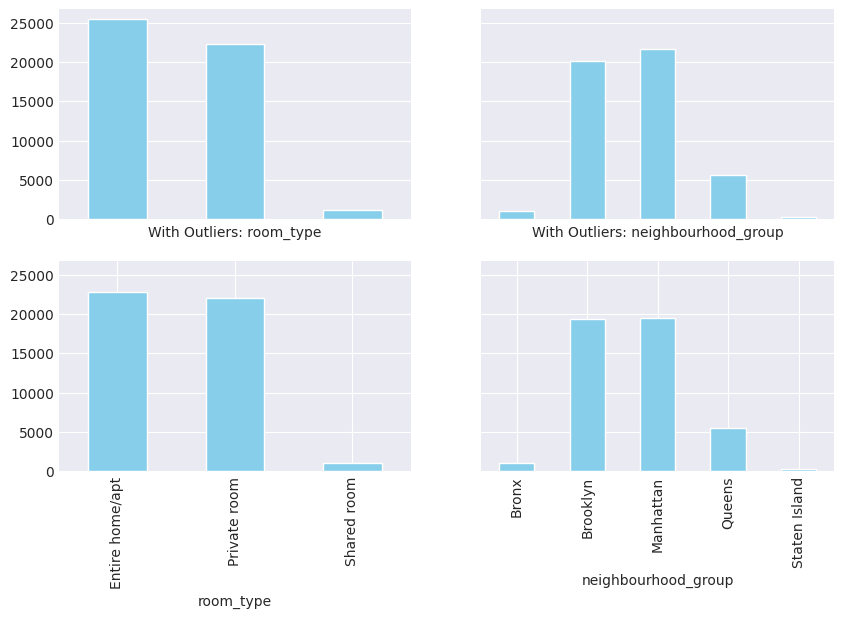

In [15]:

fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey=True)

df.groupby('room_type').size().plot(kind='bar', ax=axes[0,0], color='skyblue')
df.groupby('neighbourhood_group').size().plot(kind='bar', ax=axes[0,1], color='skyblue')
axes[0,0].set_xticks([])
axes[0,1].set_xticks([])
axes[0,0].set_xlabel('With Outliers: room_type')
axes[0,1].set_xlabel('With Outliers: neighbourhood_group')

df_clean.groupby('room_type').size().plot(kind='bar', ax=axes[1,0], color='skyblue')
df_clean.groupby('neighbourhood_group').size().plot(kind='bar', ax=axes[1,1], color='skyblue')


**Observations:**

- In both cases the general distribution remained relatively the same, however, Brooklyn and Manhattan's frequency have gotten closer.
- Many of the outliers must have been located in Manhattan.


### Price distributions before and after Outlier Removal

Text(0, 0.5, '')

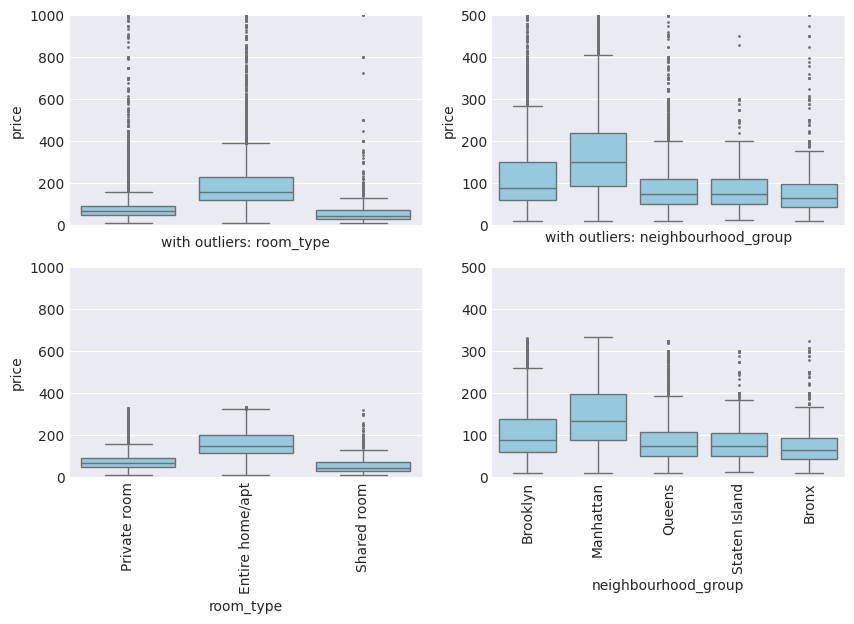

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
#plt.subplots_adjust(wspace=0.3, hspace=0.3)

# -- Original dataset

rt = sns.boxplot(data=df, x='room_type', y='price', ax=axes[0,0], fliersize=1, color='skyblue')
rt.set_ylim([0, 1000])
axes[0,0].set_xlabel('with outliers: room_type')
axes[0,0].set_xticklabels([])
axes[0,1].set_xlabel('with outliers: neighbourhood_group')

ng = sns.boxplot(data=df, x='neighbourhood_group', y='price', ax=axes[0,1], fliersize=1, color='skyblue')
ng.set_ylim([0, 500])
axes[0,1].set_xticks([])
axes[0,1].set_xticklabels([])

# -- Dataset with outliers removed

rt2 = sns.boxplot(data=df_clean, x='room_type', y='price', ax=axes[1,0], fliersize=1, color='skyblue')
rt2.set_ylim([0, 1000])
rt2.tick_params("x",labelrotation=90)

ng2 = sns.boxplot(data=df_clean, x='neighbourhood_group', y='price', ax=axes[1,1], fliersize=1, color='skyblue')
ng2.set_ylim([0, 500])
ng2.tick_params("x",labelrotation=90)
axes[1,1].set_ylabel('')

**Observations:**

Outlier removal did not have an appreciable effect on the price distributions.

## 2.5: EDA with Cleaned Data

### Price Distribution with Mean, Median, Min, Max, Q1, and Q3

119.99906342568391 100.0 10 334 65.0 159.0


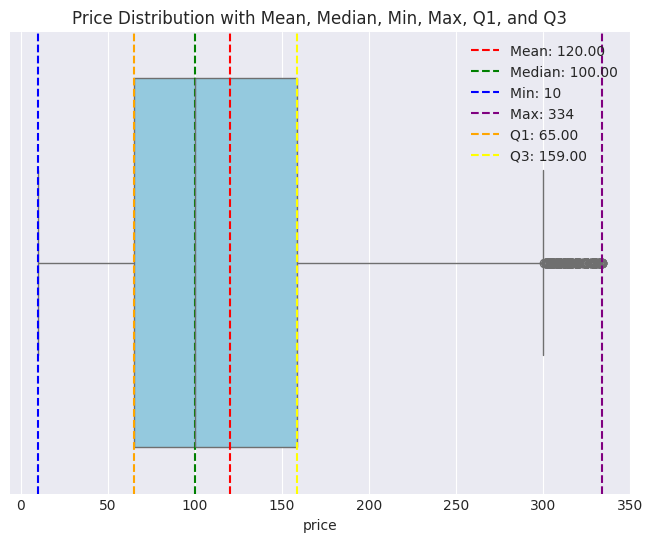

In [17]:
mean = df_clean['price'].mean()
median = df_clean['price'].median()
min_val = df_clean['price'].min()
max_val = df_clean['price'].max()
q1 = df_clean['price'].quantile(0.25)
q3 = df_clean['price'].quantile(0.75)

print(mean, median, min_val, max_val, q1, q3)

plt.figure(figsize=(8, 6))
sns.boxplot(x=df_clean['price'], color='skyblue')

# add lines for mean, median, min, max, Q1, and Q3
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='--', label=f'Median: {median:.2f}')
plt.axvline(min_val, color='blue', linestyle='--', label=f'Min: {min_val}')
plt.axvline(max_val, color='purple', linestyle='--', label=f'Max: {max_val}')
plt.axvline(q1, color='orange', linestyle='--', label=f'Q1: {q1:.2f}')
plt.axvline(q3, color='yellow', linestyle='--', label=f'Q3: {q3:.2f}')

plt.title('Price Distribution with Mean, Median, Min, Max, Q1, and Q3')
plt.legend()

**Observations:**

- The mean is greater than the median, indicating that the distribution is still right-skewed with some high-price outliers that are pushing the mean up.
The interquartile range (IQR) of 94 shows that the central 50% of prices lie within a $94 IQR range.
- There are some high-value outliers that are affecting the mean, while the median provides a better indication of the "typical" price.

### Number of listings per Neighbourhood Group

neighbourhood_group
Manhattan        19505
Brooklyn         19406
Queens            5567
Bronx             1069
Staten Island      365
Name: count, dtype: int64 



<Axes: xlabel='neighbourhood_group', ylabel='count'>

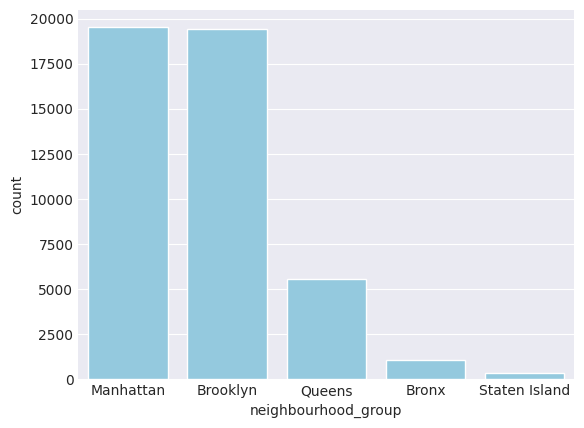

In [18]:
listings_by_neighbourhood_group = df_clean['neighbourhood_group'].value_counts()
print(listings_by_neighbourhood_group, "\n")

dist_rt_per_ng = df_clean.groupby(['neighbourhood_group', 'room_type']).size().unstack()
sns.barplot(data=listings_by_neighbourhood_group, color="skyblue")

**Observations:**
- Brooklyn and Manhattan have the highest number of listsings by a large margin.
- While Queens is ranked third, is still significantly lower than the Big-2

**Insights:**
- The lower listings listings in Queens, the Bronx and Staten island indidate there's potential for growth in these areas.
- The higher density in Manhattan and Brooklyn may indicate that these areas could demand even higher prices and that the other three may need to be priced lower, or that more effort need to be put into marketing these areas.

### Average price per Neighbourhood Group

neighbourhood_group
Manhattan        145.960318
Brooklyn         105.748634
Staten Island     89.235616
Queens            88.904437
Bronx             77.437792
Name: price, dtype: float64


<Axes: xlabel='neighbourhood_group', ylabel='price'>

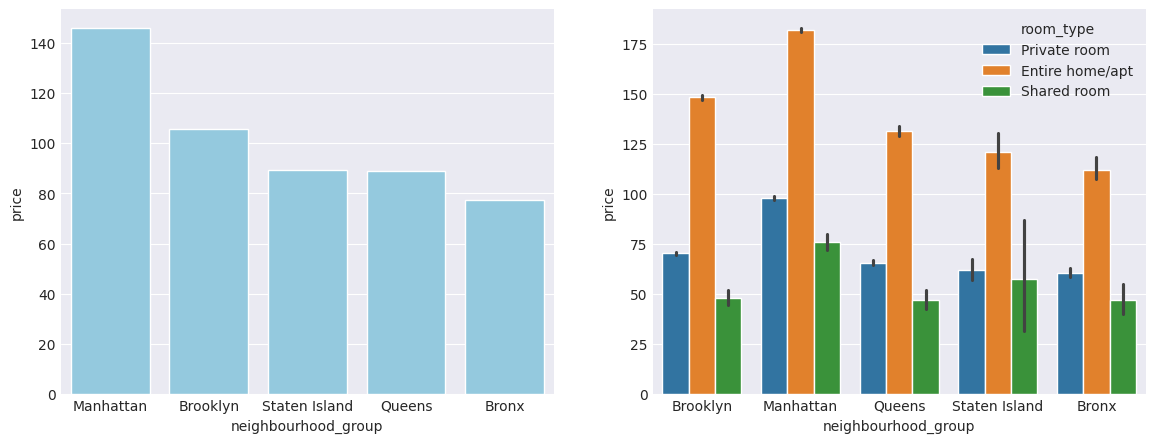

In [19]:
avg_price_per_neighbourhood_group = df_clean.groupby('neighbourhood_group')['price'].mean().sort_values(ascending=False)
print(avg_price_per_neighbourhood_group)

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=False, sharey=False)

sns.barplot(data=avg_price_per_neighbourhood_group, color="skyblue", ax=axes[0,])
sns.barplot(data=df_clean, x='neighbourhood_group', y='price', hue='room_type', ax=axes[1,])


**Observations:**
- Manhattan commands the highest prices and is in line with earlier findings on listing count.
- Brooklyn, while prices secind highest is significantly closer in price than anticipated.  

**Insights:**
- With the lower three; Staten Island, Queens and the Bronx' prices being so close to Brooklyn, this is perhaps an indication that these areas would benefit greatly from more listings given clients are willing to pay these rates.
- There is a bit more variance in the pricing of Staten Island listings that may turn off some visitors if the first listing they view is the highest.  


### Price Distribution

room_type            Entire home/apt  Private room  Shared room
neighbourhood_group                                            
Bronx                            363           647           59
Brooklyn                        8941         10056          409
Manhattan                      11293          7747          465
Queens                          2022          3351          194
Staten Island                    168           188            9 



Text(0.5, 1.0, 'Price Distribution per Neighbourhood Group')

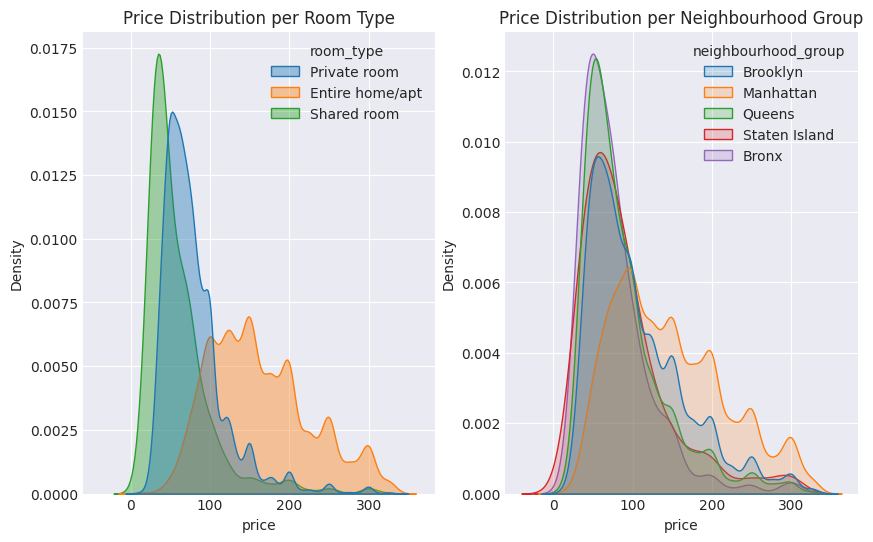

In [20]:
dist_rt_per_ng = df_clean.groupby(['neighbourhood_group', 'room_type']).size().unstack()
print(dist_rt_per_ng, "\n")


fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharex=True, sharey=False)### Missing by neighbourhood and neighbourhood group

sns.kdeplot(data=df_clean, x='price', hue="room_type", fill=True, common_norm=False, alpha=0.4, ax=axes[0,] ).set_title("Price Distribution per Room Type")
sns.kdeplot(data=df_clean, x='price', hue="neighbourhood_group", fill=True, common_norm=False, alpha=0.2, ax=axes[1,] ).set_title("Price Distribution per Neighbourhood Group")

**Observations:**
- Shared rooms occupy the lowes pricing levels and private rooms and entire home/apt's the higer pricing tiers.

**Insights:**
- Manhattan has the most listing for entire home/apt and is also commanding the highest price per listing, thereby pushing up it's relative income relative to the other groups.
- An emphasis could be places to increase listings in other neighbourhood groups for entire homes/apt to capitalize on the trend that this type of accomodation is more easily rented out.




### Relationship between Price and the number of reviews per Room Type

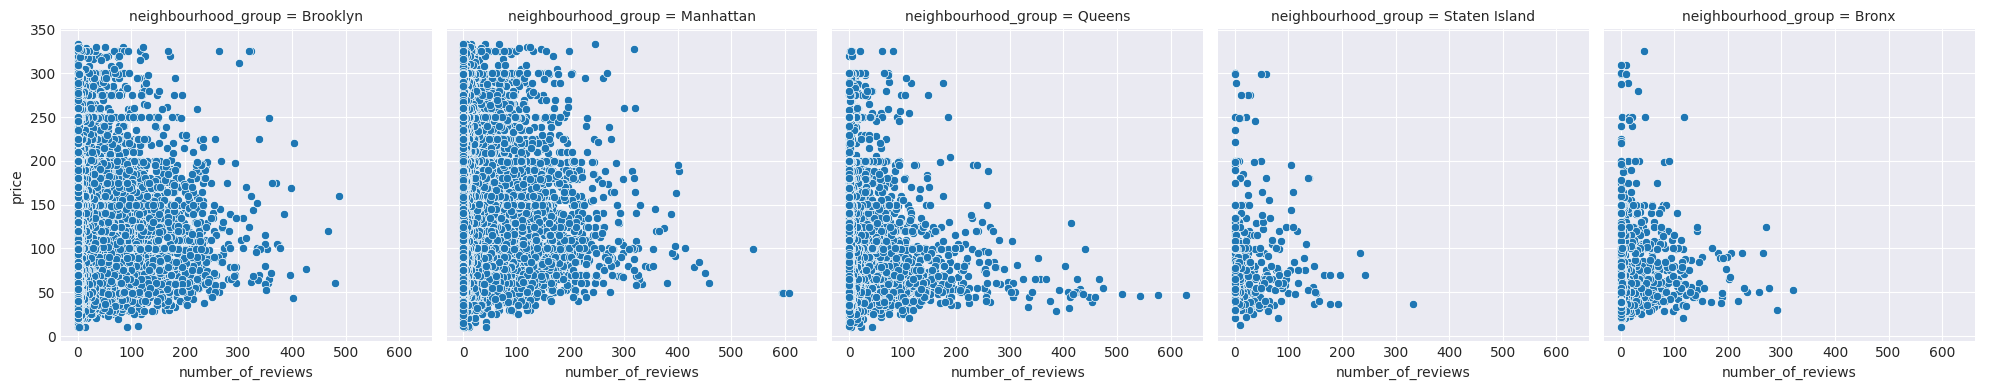

In [21]:
g = sns.FacetGrid(df_clean, col="neighbourhood_group", height=4)
g.map(sns.scatterplot, 'number_of_reviews', 'price')
g.add_legend()

### Host Analysis: Listing Count per Neighbourhood Group

In [22]:
number_of_hosts = df_clean['host_id'].nunique()

# get the listing count per host and distinguish between those with a single
# listing and those with more than one
listing_counts = df_clean.groupby(['host_id', 'host_name','neighbourhood_group'])['calculated_host_listings_count'].max()
multi_host = listing_counts[listing_counts > 1]

# get the top ten hosts and their number of listings
top_20_hosts = listing_counts.sort_values(ascending=False).head(20)

print("Total number of hosts in dataset: ", number_of_hosts)
print("Hosts with more than a single listing: ", multi_host.count())

print("\n", top_20_hosts)

Total number of hosts in dataset:  35387
Hosts with more than a single listing:  5188

 host_id    host_name          neighbourhood_group
219517861  Sonder (NYC)       Manhattan              327
107434423  Blueground         Brooklyn               232
                              Manhattan              232
30283594   Kara               Manhattan              121
137358866  Kazuya             Queens                 103
                              Brooklyn               103
                              Manhattan              103
12243051   Sonder             Manhattan               96
16098958   Jeremy & Laura     Manhattan               96
61391963   Corporate Housing  Manhattan               91
22541573   Ken                Manhattan               87
                              Brooklyn                87
200380610  Pranjal            Manhattan               65
1475015    Mike               Manhattan               52
7503643    Vida               Brooklyn                52
1207624

**Observations:**
- There are 5188 hosts that host more multiple properties on Airbnb, with many hosting in the double and/or triple digits.
- Most of these are located in Manhatten and Brooklyn and Queens a distant third.

**Insights:**
-

### Host Analysis: Listing Count per Neighbourhood Group

In [23]:
number_of_hosts = df_clean['host_id'].nunique()

# get the listing count per host and distinguish between those with a single
# listing and those with more than one
listing_counts = df_clean.groupby(['host_id', 'host_name','neighbourhood_group'])['calculated_host_listings_count'].max()
multi_host = listing_counts[listing_counts > 1]

# get the top ten hosts and their number of listings
top_20_hosts = listing_counts.sort_values(ascending=False).head(20)

print("Total number of hosts in dataset: ", number_of_hosts)
print("Hosts with more than a single listing: ", multi_host.count())

print("\n", top_20_hosts)

Total number of hosts in dataset:  35387
Hosts with more than a single listing:  5188

 host_id    host_name          neighbourhood_group
219517861  Sonder (NYC)       Manhattan              327
107434423  Blueground         Brooklyn               232
                              Manhattan              232
30283594   Kara               Manhattan              121
137358866  Kazuya             Queens                 103
                              Brooklyn               103
                              Manhattan              103
12243051   Sonder             Manhattan               96
16098958   Jeremy & Laura     Manhattan               96
61391963   Corporate Housing  Manhattan               91
22541573   Ken                Manhattan               87
                              Brooklyn                87
200380610  Pranjal            Manhattan               65
1475015    Mike               Manhattan               52
7503643    Vida               Brooklyn                52
1207624

### Correlation Heatmap

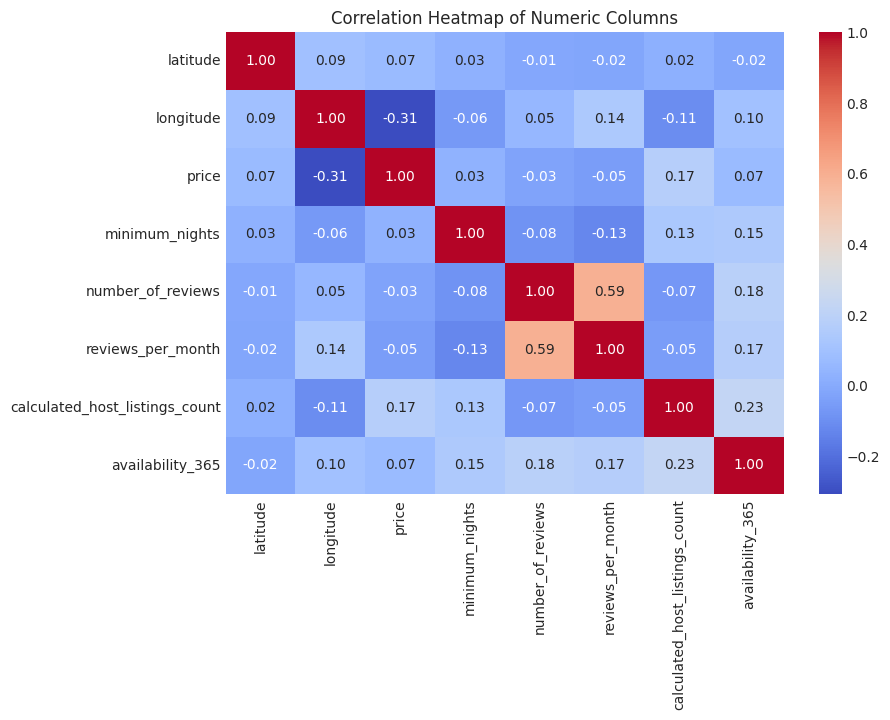

In [24]:
cols = df_clean.drop(columns=['id','host_id']).select_dtypes(include=['int', 'float']).columns

plt.figure(figsize=[9,6])
sns.heatmap(df_clean[cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Columns')
plt.show()

**Observations:**

- The correlation beteen number of reviews and reviews per month is expected given the latter is derived from the first.
- There is a correlation between longitude and price. Something we can explore using an unsupervised learning technique.

# 🔧 3. Machine Learning: K-Means Clustering

## 🛠 3.1: Setup

In [25]:
# we'll overwrite the df with the cleaned dataset
df = df_clean.copy()

## 📌 3.2: Data Preprocessing
Now that we have cleaned the dataset, we need to **prepare it for modeling** by:
1. **Encoding categorical variables** (e.g., `neighbourhood_group`, `room_type`).
2. **Selecting relevant features** for price prediction.
3. **Scaling numerical values** if needed.

---

## 1️⃣ Encoding Categorical Variables
Our dataset contains categorical columns like:
- `neighbourhood_group`
- `room_type`

### 🔹 What we will do:
✅ Convert these **categorical** columns into **numerical** format using **one-hot encoding**.  
✅ **Drop the first category** to avoid the **dummy variable trap**.

### 🔧 Code to Apply One-Hot Encoding:


In [26]:
# Convert categorical variables into numerical format using one-hot encoding
df = pd.get_dummies(df, columns=['neighbourhood_group', 'room_type'], drop_first=True)

# Show the transformed dataset
df.head()

,id,name,host_id,host_name,neighbourhood,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group_Brooklyn,neighbourhood_group_Manhattan,neighbourhood_group_Queens,neighbourhood_group_Staten Island,room_type_Private room,room_type_Shared room
0,2539,Clean & quiet apt home by the park,2787,John,Kensington,40.64749,-73.97237,149,1,9,0.21,6,365,True,False,False,False,True,False
1,2595,Skylit Midtown Castle,2845,Jennifer,Midtown,40.75362,-73.98377,225,1,45,0.38,2,355,False,True,False,False,False,False
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Harlem,40.80902,-73.94190,150,3,0,0.00,1,365,False,True,False,False,True,False
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Clinton Hill,40.68514,-73.95976,89,1,270,4.64,1,194,True,False,False,False,False,False
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,East Harlem,40.79851,-73.94399,80,10,9,0.10,1,0,False,True,False,False,False,False


## 📌 Step 3.3: Feature Selection
Now that we have converted categorical variables into numerical format, we need to **select relevant features** for price prediction.

---

## 1️⃣ Why Feature Selection?
Not all columns are useful for predicting price. **Including irrelevant features can reduce model accuracy.**  
We will **select only important features** that impact Airbnb pricing.

### 🔹 Features We Will Use:
✅ **Location** → `latitude`, `longitude`  
✅ **Listing characteristics** → `minimum_nights`, `number_of_reviews`, `calculated_host_listings_count`  
✅ **Neighborhood & Room Type (Encoded)** → Newly created one-hot encoded columns

---

## 2️⃣ Selecting Features for Modeling
We will now **define the feature set (X) and target variable (y)**.

### 🔧 Code to Select Features:



In [27]:
# Define the feature set (X) and target variable (y)
features = ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count']

# Include all one-hot encoded columns for 'neighbourhood_group' and 'room_type'
features += [col for col in df.columns if col.startswith('neighbourhood_group_') or col.startswith('room_type_')]

# Define X (independent variables) and y (target variable)
X = df[features]
y = df['price']

# Display the selected feature columns
print("Selected Features:", features)

Selected Features: ['latitude', 'longitude', 'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'neighbourhood_group_Brooklyn', 'neighbourhood_group_Manhattan', 'neighbourhood_group_Queens', 'neighbourhood_group_Staten Island', 'room_type_Private room', 'room_type_Shared room']


## 📌 Step 3.4: Splitting the Data for Training & Testing
Now that we have selected the relevant features, we need to **split the dataset** into a **training set** and a **testing set**.

---

## 1️⃣ Why Split the Data?
To build a reliable model, we need to:
- **Train the model** on **80% of the data**.
- **Test the model** on **20% of the data** to check accuracy.

This prevents **overfitting**, where the model memorizes the training data instead of learning patterns.

---

## 2️⃣ Splitting the Dataset
We will use **scikit-learn's** `train_test_split` function to:
✅ **Randomly split the data** into 80% training and 20% testing.  
✅ **Ensure reproducibility** by setting a `random_state`.

### 🔧 Code to Split the Data:


In [28]:
from sklearn.model_selection import train_test_split

# Split dataset: 80% for training, 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Show the shape of the training and testing sets
print("Training Set Shape:", X_train.shape, y_train.shape)
print("Testing Set Shape:", X_test.shape, y_test.shape)

Training Set Shape: (36729, 11) (36729,)
Testing Set Shape: (9183, 11) (9183,)


## 📌 Step 3.5: Training an Unsupervised Machine Learning Model
Now that we have prepared our dataset, we will **train an unsupervised learning model** to **identify price patterns**.

---

## 1️⃣ Why Use Unsupervised Learning?
Since we want to **optimize pricing dynamically**, an **unsupervised learning approach** will help us:
✅ **Cluster similar Airbnb listings** based on price-related attributes.  
✅ **Identify groups with similar pricing patterns**.  
✅ **Recommend dynamic pricing adjustments** for inactive hosts.

---

## 2️⃣ Choosing the Clustering Algorithm
We will use **K-Means Clustering**, which:
- Groups similar listings into **clusters** based on pricing and features.
- Helps us find **patterns in pricing strategies**.
- Works well for **dynamic pricing adjustments**.

---

## 3️⃣ Applying K-Means Clustering
We will:
✅ **Standardize numerical features** to improve clustering.  
✅ **Use the Elbow Method** to determine the best number of clusters.  
✅ **Train the K-Means model** and analyze the clusters.

### 🔧 Code to Apply K-Means Clustering:


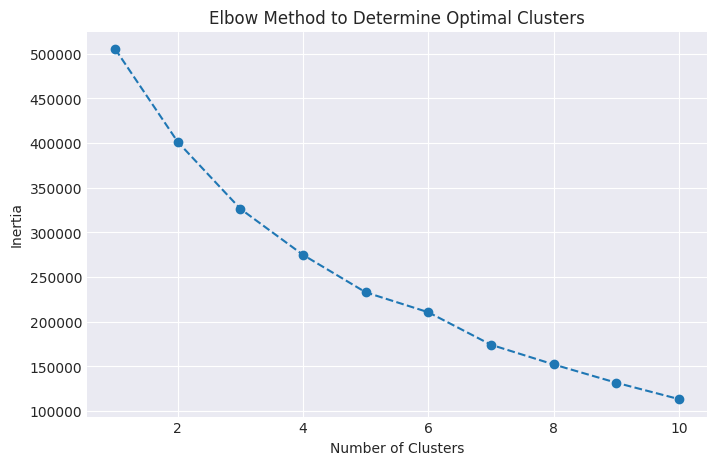

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Standardizing the numerical features for better clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Finding the optimal number of clusters using the Elbow Method
inertia = []
cluster_range = range(1, 11)  # Testing cluster sizes from 1 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.show()

## 📌 Step 3.6: Training the K-Means Model & Analyzing Clusters
Now that we have determined the optimal number of clusters using the **Elbow Method**, we will **train the final K-Means model** and analyze the clusters.

---

## 1️⃣ Why K-Means Clustering?
By training the **K-Means model**, we will:
✅ **Group similar Airbnb listings** based on their features.  
✅ **Identify distinct pricing segments**.  
✅ **Recommend pricing strategies for inactive hosts** based on their cluster.

---

## 2️⃣ Training the Final K-Means Model
We will now:
✅ **Train K-Means** with the optimal number of clusters.  
✅ **Assign each listing to a cluster**.  
✅ **Analyze the characteristics of each cluster**.

### 🔧 Code to Train K-Means & Assign Clusters:



In [30]:
# Set the optimal number of clusters (replace X with the best number from the Elbow Method)
optimal_clusters = 4  # Example: If the elbow point is at 4, change X to 4

# Train the K-Means model with the correct cluster number
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)

# Assign cluster labels to the dataframe
df['cluster'] = kmeans.fit_predict(X_scaled)

# Display the first few rows with cluster assignments
df[['name', 'price', 'cluster']].head()


,name,price,cluster
0,Clean & quiet apt home by the park,149,0
1,Skylit Midtown Castle,225,2
2,THE VILLAGE OF HARLEM....NEW YORK !,150,2
3,Cozy Entire Floor of Brownstone,89,0
4,Entire Apt: Spacious Studio/Loft by central park,80,2


### 🔧 Code to Visualize Clusters:

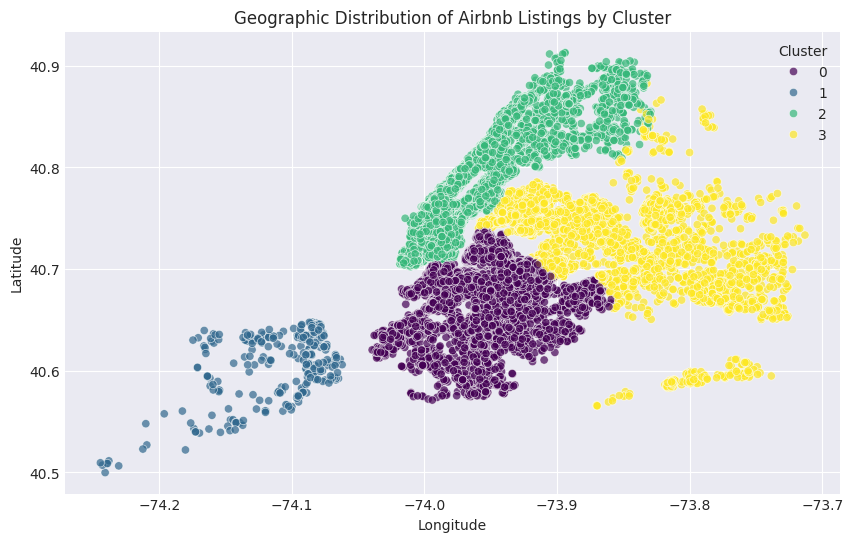

In [31]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=df['cluster'], palette='viridis', alpha=0.7)
plt.title("Geographic Distribution of Airbnb Listings by Cluster")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(title="Cluster")
plt.show()


### 📌 Understanding Clusters in K-Means
In **K-Means Clustering**, we group similar Airbnb listings into different **clusters** based on their features.

Each listing is **assigned a cluster label**, typically represented as **0, 1, 2, 3, ...** (depending on the number of clusters we chose).

---

### 🔍 What Do Cluster Labels Represent?
Each **cluster (0, 1, 2, 3, ...)** represents a **group of listings that share similar characteristics**, such as:
✅ **Price**  
✅ **Location (latitude & longitude)**  
✅ **Minimum nights required**  
✅ **Availability**  
✅ **Reviews & popularity**  

---

### 📊 Example: Airbnb Listings Grouped by Clusters
| Listing Name                  | Price ($) | Cluster |
|--------------------------------|----------|---------|
| "Luxury Apartment in Manhattan" | 250      | 0       |
| "Budget Room in Brooklyn"       | 50       | 1       |
| "Cozy Studio in Queens"         | 80       | 2       |
| "High-End Loft in NYC"          | 300      | 0       |
| "Affordable Stay in Bronx"      | 60       | 1       |

#### 🔹 What This Means:
- **Cluster `0` → Expensive listings** (Luxury apartments in prime locations)
- **Cluster `1` → Budget listings** (Cheaper stays, likely outside central areas)
- **Cluster `2` → Mid-range listings** (Moderate pricing)
- **Cluster `3` → Special category** (Could be rare listings with unique patterns)

Each **cluster groups similar listings together**, helping **Airbnb hosts** understand how their property is priced compared to similar listings.



## 📌 Step 3.7: Analyzing Cluster Characteristics
Now that we have assigned clusters to Airbnb listings, we will analyze them to:
✅ Find the **average price per cluster**.  
✅ Identify which clusters are **underpriced or overpriced**.  
✅ Recommend **pricing adjustments for inactive hosts**.

---

## 1️⃣ Finding the Average Price Per Cluster
We will calculate the **mean price** for each cluster to understand pricing differences.

### 🔧 Code to Calculate Average Price Per Cluster:



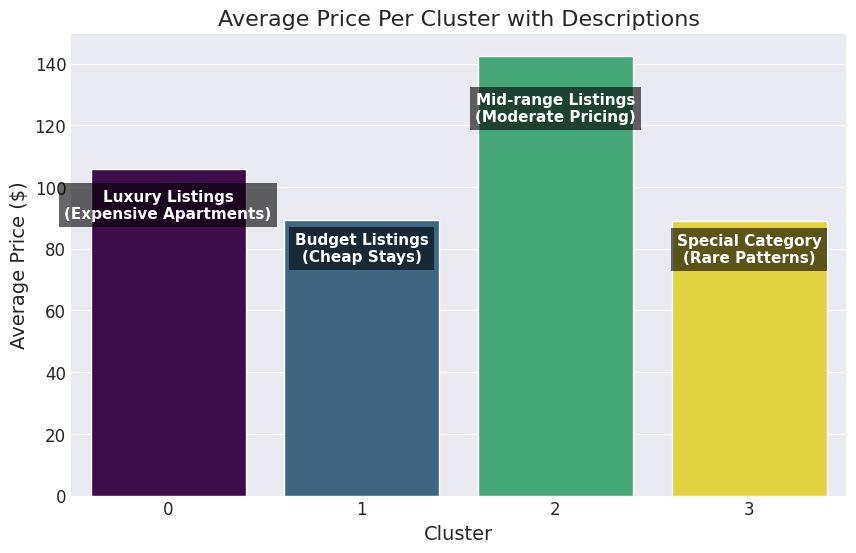

,Cluster,Average Price
0,0,105.750013
1,1,89.235616
2,2,142.600839
3,3,88.845895


In [32]:
# Calculate average price per cluster
cluster_avg_price = df.groupby('cluster')['price'].mean().reset_index()
cluster_avg_price.columns = ['Cluster', 'Average Price']

# Cluster descriptions
cluster_descriptions = {
    0: "Luxury Listings\n(Expensive Apartments)",
    1: "Budget Listings\n(Cheap Stays)",
    2: "Mid-range Listings\n(Moderate Pricing)",
    3: "Special Category\n(Rare Patterns)"
}

# Display the results
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# FIX: Assign 'hue' to avoid FutureWarning
ax = sns.barplot(x='Cluster', y='Average Price', data=cluster_avg_price, hue='Cluster', palette='viridis')
ax.legend_.remove()  # Remove legend since hue is just for color assignment

# Adjust text placement dynamically inside bars
for index, row in cluster_avg_price.iterrows():
    plt.text(row['Cluster'], row['Average Price'] * 0.85,   # Position text slightly lower than max height
             cluster_descriptions.get(row['Cluster'], ""),
             ha='center', fontsize=11, fontweight='bold', color='white',
             bbox=dict(facecolor='black', alpha=0.6, edgecolor='none'))

plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Average Price ($)", fontsize=14)
plt.title("Average Price Per Cluster with Descriptions", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# Display the cluster pricing summary
cluster_avg_price


## 📌 Step 3.8: Analyzing Availability & Location Patterns
Now that we have identified **pricing clusters**, we will analyze:
✅ **Availability patterns** – How often listings in each cluster are available.  
✅ **Geographical distribution** – Where each price cluster is located.

---

## 1️⃣ Checking Availability by Cluster
We will calculate **average availability** for each cluster to see:
- Which clusters have the highest/lowest availability.
- Whether **luxury listings** are booked less frequently.
- Whether **budget listings** have higher availability.

### 🔧 Code to Analyze Availability:


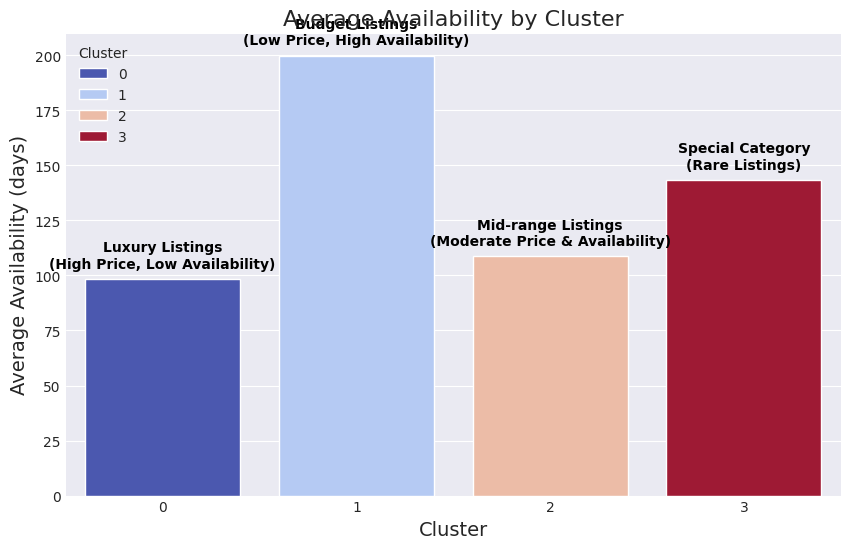

,Cluster,Average Availability (days)
0,0,98.476578
1,1,199.893151
2,2,108.721358
3,3,143.403972


In [33]:

# Calculate average availability per cluster
cluster_availability = df.groupby('cluster')['availability_365'].mean().reset_index()
cluster_availability.columns = ['Cluster', 'Average Availability (days)']

# Cluster descriptions
cluster_descriptions = {
    0: "Luxury Listings\n(High Price, Low Availability)",
    1: "Budget Listings\n(Low Price, High Availability)",
    2: "Mid-range Listings\n(Moderate Price & Availability)",
    3: "Special Category\n(Rare Listings)"
}

# Visualize the availability
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Cluster', y='Average Availability (days)', data=cluster_availability, hue='Cluster', palette='coolwarm')

# Add text labels to the bars
for index, row in cluster_availability.iterrows():
    plt.text(row['Cluster'], row['Average Availability (days)'] + 5,  # Position text slightly above bars
             cluster_descriptions.get(row['Cluster'], ""),
             ha='center', fontsize=10, fontweight='bold', color='black')

plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Average Availability (days)", fontsize=14)
plt.title("Average Availability by Cluster", fontsize=16)
plt.legend(title="Cluster")
plt.show()

# Display the availability summary
cluster_availability


In [34]:
import folium
from folium.plugins import MarkerCluster

# Define a base map centered around NYC
map_nyc = folium.Map(location=[40.7128, -74.0060], zoom_start=11)

# Add clusters to the map
marker_cluster = MarkerCluster().add_to(map_nyc)

# Assign colors to clusters
cluster_colors = {
    0: "darkpurple",  # Luxury Listings (High Price, Low Availability)
    1: "blue",        # Budget Listings (Low Price, High Availability)
    2: "green",       # Mid-range Listings (Moderate Price & Availability)
    3: "orange"       # Special Category (Rare Listings)
}

# Add points to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=(row["latitude"], row["longitude"]),
        radius=3,
        color=cluster_colors[row["cluster"]],
        fill=True,
        fill_color=cluster_colors[row["cluster"]],
        fill_opacity=0.7,
        popup=f"Cluster: {row['cluster']}\nPrice: ${row['price']}"
    ).add_to(marker_cluster)

# Add a legend manually
legend_html = '''
<div style="position: fixed;
            bottom: 50px; left: 50px; width: 250px; height: 140px;
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
    <b>Cluster Legend</b><br>
    <span style="color:darkpurple">&#9679;</span> Luxury Listings (High Price, Low Availability) <br>
    <span style="color:blue">&#9679;</span> Budget Listings (Low Price, High Availability) <br>
    <span style="color:green">&#9679;</span> Mid-range Listings (Moderate Price & Availability) <br>
    <span style="color:orange">&#9679;</span> Special Category (Rare Listings) <br>
</div>
'''
map_nyc.get_root().html.add_child(folium.Element(legend_html))

# Show the map
map_nyc


Output hidden; open in https://colab.research.google.com to view.

## 📌 Step 3.9: Dynamic Price Recommendations
Now that we have analyzed **price clusters and availability patterns**, we will generate **dynamic price recommendations** for inactive Airbnb listings.

---

## 1️⃣ How We Will Recommend Prices
We will use the **pricing insights from active listings** to **suggest competitive prices** for inactive hosts based on their cluster.  
🔹 Inactive hosts are listings with **0 reviews** (never booked before).  
🔹 We will assign an **optimal price** based on the **average price of their cluster**.

---

## 2️⃣ Generating Recommended Prices
We will:
✅ **Identify inactive listings** (listings with 0 reviews).  
✅ **Assign them to a cluster** based on their features.  
✅ **Recommend a price** based on the **average price of their cluster**.  

### 🔧 Code to Generate Price Recommendations:


In [35]:
# Identify inactive listings (listings with 0 reviews)
inactive_hosts = df[df['number_of_reviews'] == 0].copy()

# Merge inactive listings with cluster average prices
#inactive_hosts = inactive_hosts.merge(cluster_avg_price, on='cluster', how='left')
inactive_hosts = inactive_hosts.merge(cluster_avg_price, left_on='cluster', right_on='Cluster', how='left')

# Create a new column for recommended price
inactive_hosts['recommended_price'] = inactive_hosts['Average Price']

# Display recommended prices for inactive listings
inactive_hosts[['name', 'cluster', 'price', 'recommended_price']].head()

,name,cluster,price,recommended_price
0,THE VILLAGE OF HARLEM....NEW YORK !,2,150,142.600839
1,Huge 2 BR Upper East Cental Park,2,190,142.600839
2,Magnifique Suite au N de Manhattan - vue Cloitres,2,80,142.600839
3,Clean and Quiet in Brooklyn,0,35,105.750013
4,Country space in the city,0,150,105.750013


### 🔍 Impact on pricing

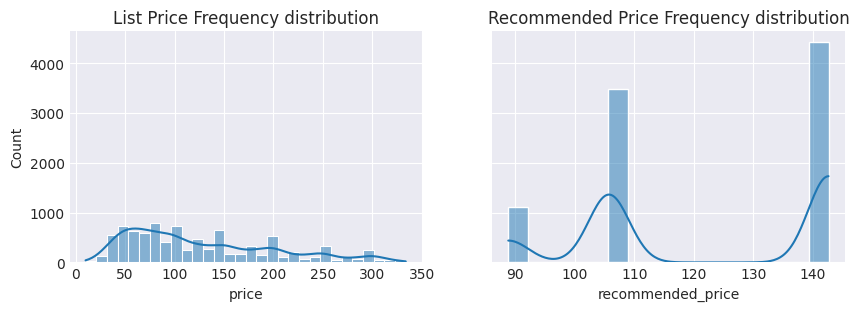

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

sns.histplot(data=inactive_hosts, x='price', kde=True, ax=axes[0,]).set_title('List Price Frequency distribution')
sns.histplot(data=inactive_hosts, x='recommended_price', kde=True, ax=axes[1,]).set_title('Recommended Price Frequency distribution')

# remove labels
plt.gca().spines[['top', 'right',]].set_visible(False)

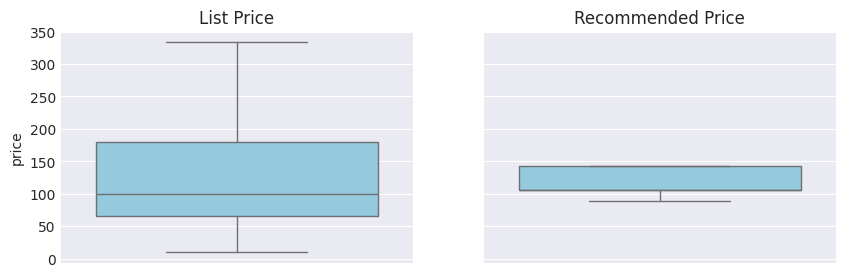

In [37]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

bp_price = sns.boxplot(data=inactive_hosts, y='price', ax=axes[0,], fliersize=1, color='skyblue').set_title('List Price')
bp_predicted = sns.boxplot(data=inactive_hosts, y='recommended_price', ax=axes[1,], fliersize=1, color='skyblue').set_title('Recommended Price')